In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from utilities import constants
plt.rcParams['text.usetex'] = True

# import scienceplots

# plt.style.use('science')

In [27]:
# fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
# fig.tight_layout()


# activation = activation=keras.activations.relu


# for idx, x_name in enumerate(x_array):
#     for idy, y_name in enumerate(y_array):
#         cur_x, cur_y = eval(x_name), eval(y_name)
        

#         for name_transformation, func_transformation in tranformations.items():
#             transformed_x = func_transformation(cur_x)
#             try:
#                 model = MLP(transformed_x.shape[1], 1, 1024, depth=2, activation=activation)
#                 model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
#                 model.fit(transformed_x, cur_y, epochs=1000, verbose=0)
#                 y_hat = model.predict(transformed_x)
#                 score = mse(y_hat, cur_y)
#                 print(f"{score} : {name_transformation}")
#                 ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
#             except:
#                 print(name_transformation, 'NANS')


#         ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

#         ax[idx, idy].set_title(f'{x_name}/{y_name}')
#         ax[idx, idy].legend()
# plt.suptitle('MLP', y=1.02)
# plt.show()

In [28]:
with open('results.pkl', 'rb') as f:
    x = pickle.load(f)

In [29]:
df = pd.json_normalize(x)

In [36]:
xy_arrays = df.groupby(['x', 'y']).size().index.to_list()

In [15]:
# def plot_lines(ax, confidence=True):
#     for row, name in zip([intact, standardization, standardization_and_intact], ['intact', 'standardization', 'standardization$\displaystyle\mathbin\Vert$intact']):
#         ax.plot(func(row).mean(axis=0), label=name)
#         if confidence:
#             ax.fill_between(range(1000), (func(row).mean(axis=0)-2*func(row).std(axis=0)), (func(row).mean(axis=0)+2*func(row).std(axis=0)), alpha=.15)    

# slice_from = -50
# x_row = intact.shape[1]
# fig, ax = plt.subplots(1, 1, figsize=(16,10))

    

# plot_lines(ax)

# plt.legend(fontsize=20)
# ax.set_xlim(0, x_row)
# ax.set_xlabel("Epochs", size=20)
# ax.set_ylabel("Log2 MSE", size=20)
# plt.tight_layout()

# axins = zoomed_inset_axes(ax, zoom=7, bbox_to_anchor=(0.95, -0.3, 0, 1), bbox_transform=ax.transAxes)
# plot_lines(axins, confidence=False)
# axins.set_xlim(x_row+slice_from, x_row)
# axins.set_ylim(-9.5, -8.5)

# plt.xticks(visible=False)

# # Mark the area on the original plot that is being zoomed in on
# mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

# plt.suptitle(f'$\displaystyle X \sim N(6, 3)$ \n $Y \sim Exp(6, 3)$', size=25)
# plt.show()

In [56]:
base_array = [2, 3, 4, 8, 16, 32, 36]
font_size_sublabels = 15
dist_names = {'norm': f'N({constants.DISTS_LOC}, {constants.DISTS_SCALE})',
              'lognorm': f'LN({constants.DISTS_LOC}, {constants.DISTS_SCALE})',
              'expon': f'Exp({constants.DISTS_LOC}, {constants.DISTS_SCALE})'}
params = np.array(['norm', 'keep_origin','only_integers'])
slice_from = 0
func = np.log2

for x, y in xy_arrays:
    for base in base_array:
        if x == 'norm' and y =='norm':
            continue
        mask = (df['x']==x)&(df['y']==y)
        ne = df[mask&(df['params.base']==base)]
        intact = np.array(df[mask&(df['transformation_name']=="intact")]["history"].to_list())
        standardization = np.array(df[mask&(df['transformation_name']=="standardization")&(df['params.keep_origin']==False)]["history"].to_list())
        standardization_and_intact = np.array(df[mask&(df['transformation_name']=="standardization")&(df['params.keep_origin']==True)]["history"].to_list())
        baselines = {'intact':intact, 'standardization':standardization} 

        for check_difference in params:
            left = params[params != check_difference]
            linewidth = 0.9
            fig, ax = plt.subplots(2, 2, figsize=(16,10), sharex=True, sharey=True)
            for idy, left_0 in enumerate([False, True]):
                for idx, left_1 in enumerate([False, True]):
                    for loss_name, loss in baselines.items():
                        ax[idy, idx].plot(func(loss.mean(axis=0))[slice_from:], label=loss_name, alpha=0.6, linewidth=linewidth)
                    loss_0 = func(np.array(ne[(ne[f'params.{left[0]}']==left_0)&(ne[f'params.{left[1]}']==left_1)&(ne[f'params.{check_difference}']==False)]['history'].to_list()).mean(axis=0)[slice_from:])
                    loss_1 = func(np.array(ne[(ne[f'params.{left[0]}']==left_0)&(ne[f'params.{left[1]}']==left_1)&(ne[f'params.{check_difference}']==True)]['history'].to_list()).mean(axis=0)[slice_from:])
                    ax[idy, idx].plot(loss_0, '-', label=f'{check_difference}=False', linewidth=linewidth-0.2, alpha=0.8)
                    ax[idy, idx].plot(loss_1, '-', label=f'{check_difference}=True', linewidth=linewidth-0.2, alpha=0.8)
                    xticks = list(range(0, len(loss_0)+1, 100))
                    ax[idy, idx].set_xticks(xticks, labels=list(range(slice_from, len(loss_0)+slice_from+1, 100)))

            plt.suptitle(f'Base {base}', size=25)
            fig.text(0.01, 0.01, f'$\displaystyle X \sim {dist_names[x]}$\n$Y \sim {dist_names[y]}$', alpha=0.4, size=25)
            ax[0, 0].set_ylabel(f"{left[0]}=False", size=font_size_sublabels)
            ax[1, 0].set_ylabel(f"{left[0]}=True", size=font_size_sublabels)
            ax[0, 0].xaxis.set_label_position('top')
            ax[0, 1].xaxis.set_label_position('top')

            ax[0, 0].set_xlabel(f"{left[1]}=False", size=font_size_sublabels)
            ax[0, 1].set_xlabel(f"{left[1]}=True", size=font_size_sublabels)
            ax[0, 1].legend(prop={'size': 15})
            fig.text(0.5, 0.04, 'Epochs', ha='center', size=20)
            fig.text(0.04, 0.5, f"{func.__name__} MSE", va='center', rotation='vertical', size=20)
            fig.text(1, 0.01, '*Curves are averaged over 5 experiments', alpha=0.3, size=15, ha='right')
            path = f"plots/x_{x}_y_{y}"
            if not os.path.exists(path):
                os.mkdir(path)
            plt.savefig(f'{path}/base_{base}_{check_difference}.png')
            plt.close()

In [54]:
bools = [False, True]
linewidth = 2
baseline_step = 1
# base_array = [2, 3, 4]


for x, y in xy_arrays:
    mask = (df['x']==x)&(df['y']==y)
    ne = df[mask&(df['params.base']!=10)]
    intact = np.array(df[mask&(df['transformation_name']=="intact")]["history"].to_list())
    standardization = np.array(df[mask&(df['transformation_name']=="standardization")&(df['params.keep_origin']==False)]["history"].to_list())
    standardization_and_intact = np.array(df[mask&(df['transformation_name']=="standardization")&(df['params.keep_origin']==True)]["history"].to_list())

    for norm in bools:
        for keep_origin in bools:
            for only_integers in bools:
                fig, ax = plt.subplots(1, 1, figsize=(16,10))

                # Baseline plotting
                for (loss_name, loss), c, m in zip(baselines.items(), ['0.6', '0.3'], ['-', '--']):
                    ax.plot(np.arange(constants.EPOCHS)[slice_from::baseline_step], func(loss.mean(axis=0)[slice_from::baseline_step]), m, c=c, label=loss_name, linewidth=linewidth, zorder=10)
                # Different bases
                color = iter(plt.cm.summer(np.linspace(0, 1, len(base_array))))

                for base in base_array:
                    c = next(color)
                    loss_0 = func(np.array(ne[(ne['params.base']==base)&(ne['params.norm']==norm)&(ne['params.keep_origin']==keep_origin)&(ne['params.only_integers']==only_integers)]['history'].to_list()).mean(axis=0)[slice_from:])
                    ax.plot(loss_0, '-', label=f'base {base}',c=c, linewidth=linewidth-0.2, alpha=0.8)
                    xticks = list(range(0, len(loss_0)+1, 100))
                    ax.set_xticks(xticks, labels=list(range(slice_from, len(loss_0)+slice_from+1, 100)))

                plt.suptitle(f'Base comparison', size=25)
                fig.text(0.01, 0.01, f'$\displaystyle X \sim {dist_names[x]}$\n$Y \sim {dist_names[y]}$', alpha=0.4, size=25)               
                fig.text(1, 0.01, '*Curves are averaged over 5 experiments', alpha=0.3, size=15, ha='right')

                fig.text(0.6, 0.7, f'normalization {norm}\nkeep_origin   {keep_origin}\nonly_integers {only_integers}', alpha=0.4, size=25, ha='right')               

                ax.legend(prop={'size': 15})
                ax.set_ylabel(f"{func.__name__} MSE", size=20)
                ax.set_xlabel(f"Epochs", size=20)
                
                path = f"plots/x_{x}_y_{y}/base_comparison"
                if not os.path.exists(path):
                    os.mkdir(path)
                plt.savefig(f'{path}/{norm}_{keep_origin}_{only_integers}.png')
                plt.close()

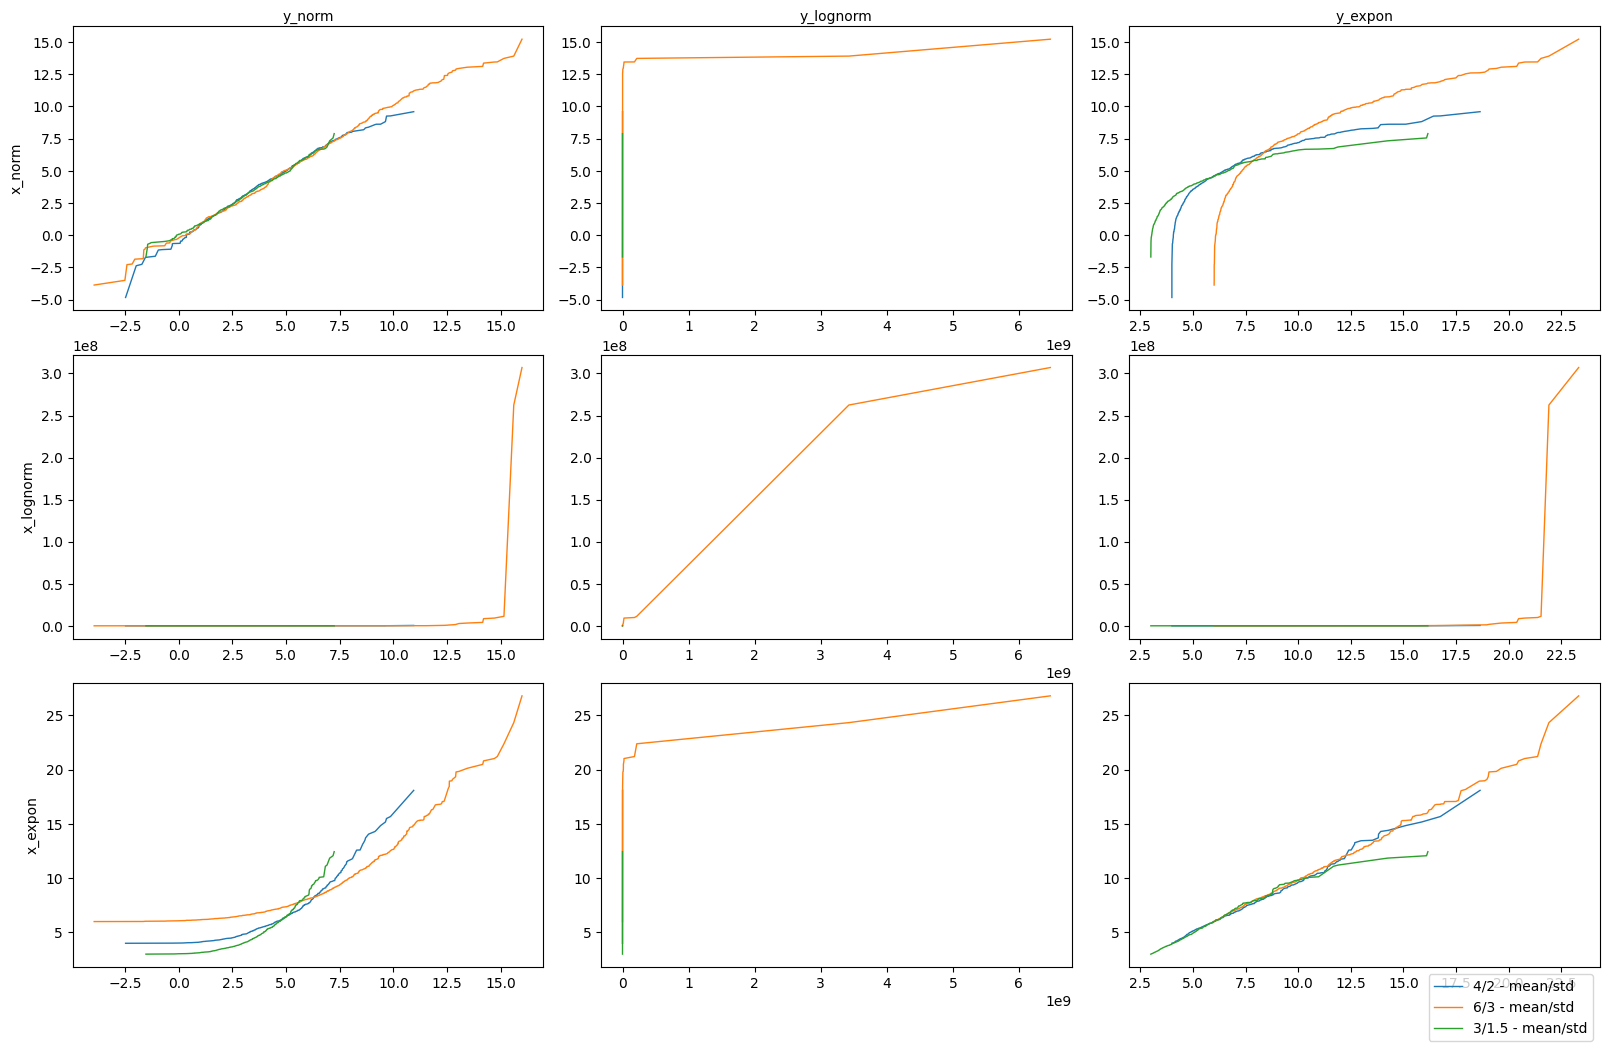

In [543]:
from scipy.stats import expon, norm, lognorm, laplace, cauchy, loguniform, uniform


n_samples = 1000
inflated = 12
n_features = 1
# x_1 = np.random.normal(2, 0.5, [n_samples-inflated, 1])
# x_2 = np.random.normal(0, 0, [inflated, 1])
# x = np.vstack((x_1, x_2))
a = 1
b = 2
num_of_distr = 3
fig, ax = plt.subplots(num_of_distr, num_of_distr, figsize=(16, 10))
fig.tight_layout()

for mean, std in zip([4, 6, 3], [2, 3, 1.5]):
        
    dists = [
        {'norm': {
            'loc':mean,
            'scale':std
            }
        },
        {'lognorm': {
            's':mean,
            'loc':mean,
            'scale':std
            }
        },
        {'expon': {
            'loc':mean,
            'scale':std
            }
        },
#         {'cauchy': {
#             'loc':mean,
#             'scale':std
#             }
#         },
#         {'laplace': {
#             'loc':mean,
#             'scale':std
#             }
#         },
#         {'loguniform': {
#             'a': a,
#             'b': b,
#             'loc':mean,
#             'scale':std
#             }
#         },
#         {'uniform': {
#             'loc':mean,
#             'scale':std
#             }
#         },
    ]

    x, y = dict(), dict()

    for gen in dists:
        for dist_name, params in gen.items():
            x[dist_name] = eval(dist_name).rvs(size=[n_samples, n_features], **params)
            y[dist_name] = eval(dist_name).rvs(size=n_samples, **params)


    for idx, (x_name, x_value) in enumerate(x.items()):
        for idy, (y_name, y_value) in enumerate(y.items()):

            order_x = np.argsort(x_value, axis=0).ravel()
            order_y = np.argsort(y_value, axis=0).ravel()

            ax[idy, idx].plot(x_value[order_x], y_value[order_y], linewidth=1, label=f'{mean}/{std} - mean/std')


    for i, name in enumerate(x.keys()):
        ax[i, 0].set_ylabel(f'x_{name}')
    for i, name in enumerate(y.keys()):
        ax[0, i].set_xlabel(f'y_{name}')
        ax[0, i].xaxis.set_label_position('top')
        
plt.legend(loc='upper right', bbox_to_anchor=(1,0))
plt.show()

In [64]:
import struct

In [116]:
struct.unpack('i', struct.pack('f', float_num))

(1045220557,)

In [113]:
struct.unpack('i', struct.pack('f', float_num))

(1045220557,)

In [108]:
float_num = 0.2   # float number to convert
binary_num = bin(struct.unpack('i', struct.pack('f', float_num))[0])[2:]
print(binary_num)

111110010011001100110011001101


In [110]:
temp = 0
for i, val in enumerate(binary_num, start=1):
    temp += int(val)*2**(-i)
print(temp)

0.9734375001862645


In [42]:
import numpy as np

# Sample input
x = np.array([0.625, -12., 36.12])

# Extract the mantissa from the output of np.frexp
mantissa, exponent = np.frexp(x)

# Number of bits to represent the mantissa
num_bits = 8

# Multiply the mantissa by 2 to the power of num_bits
mantissa *= 2 ** num_bits

# Convert to integer
mantissa_int = mantissa.astype(int)

# Convert to binary
mantissa_bin = [bin(m)[2:].zfill(num_bits) for m in mantissa_int]

# Print the results
print("Input:", x)
print("Mantissa:", mantissa)
print("Mantissa (integer):", mantissa_int)
print("Mantissa (binary):", mantissa_bin)


Input: [  0.625 -12.     36.12 ]
Mantissa: [ 160.   -192.    144.48]
Mantissa (integer): [ 160 -192  144]
Mantissa (binary): ['10100000', 'b11000000', '10010000']


In [36]:
x = np.array([0.625, 1.25, 2.5])

# Extract the mantissa from the output of np.frexp
mantissa, exponent = np.frexp(x)